In [14]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
from pathlib                            import Path
from tensorflow.keras.callbacks         import LearningRateScheduler
from tensorflow.keras.layers            import Lambda
import sys
import os
import numpy                            as np
import math
import random, time
import pandas                           as pd

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt
from decimal                        import Decimal


### <span style="color:blue">I. Load directories</span>

In [15]:
# Files path
directory_one = os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES-VER-4")
directory_two = os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES")

# Add directory to sys.path
sys.path.append(directory_one)
sys.path.append(directory_two)

# import scripts
import param 

# This script is about preprocessing the images, binary the geometry and fhe flow patterns in grayscales
from preprocessing         import *    

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# Set the number of cores
num_threads = param.n_threads  
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

### <span style="color:blue">II. Processing data</span>

In [16]:
#Load the main directory, there are paths of the flow patterns and the geometry 
paths=param.list_paths 
for i,j in enumerate(paths):
    print(f'{i} => {j}')

# Defining amount of train,valid,test images
n_train=0.8;    n_valid=0.1;    n_test=0.1

# Defining a sample i.e. 500 images
n_sample=500   #  500                                       


0 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry
1 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude
2 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Pression
3 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U001
4 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U002


#### <span style="color:blue">II.1 Split data: train, valid and test sets</span>

In [17]:
# Geometry
geo_train,geo_valid,geo_tests=split_data(paths[0],n_sample,n_train,n_valid,n_test)
geo_array_train=arrays_img_processed(geo_train)
geo_array_valid=arrays_img_processed(geo_valid)
geo_array_tests=arrays_img_processed(geo_tests)

# Magnitude
specific_tarjet=paths[1]

mag_train,mag_valid,mag_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)
mag_array_train=arrays_img_processed(mag_train,False)
mag_array_valid=arrays_img_processed(mag_valid,False)
mag_array_tests=arrays_img_processed(mag_tests,False)

print(f'Training data for geometry: {geo_array_train.shape}')
print(f'Training data for magnitude: {mag_array_train.shape}')
print()
print(f'Valid data for geometry: {geo_array_valid.shape}')
print(f'Valid data for magnitude: {mag_array_valid.shape}')
print()
print(f'Test data for geometry: {geo_array_tests.shape}')
print(f'Test data for magnitude: {mag_array_tests.shape}')


 ######  	 Loaded  500  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry 	 #####


 ######  	 Loaded  500  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude 	 #####

Training data for geometry: (399, 128, 256, 1)
Training data for magnitude: (399, 128, 256, 1)

Valid data for geometry: (49, 128, 256, 1)
Valid data for magnitude: (49, 128, 256, 1)

Test data for geometry: (49, 128, 256, 1)
Test data for magnitude: (49, 128, 256, 1)


### <span style="color:blue">III. Setup hiperparameters</span>


In [18]:
# Dimentions of input data
h=128
w=256
ch=1 # Channel 
num_epochs=150
batch_size=50
patience=100   # How long to wait after last time validation loss improved  
LR=0.001                                 
DECAY_RATE=0.015

# Constans for loss and metric functions
eps = 1e-4
C = 1e-2
   

#### <span style="color:blue">III.1. Learning rate schedule: Learning rate variable</span>



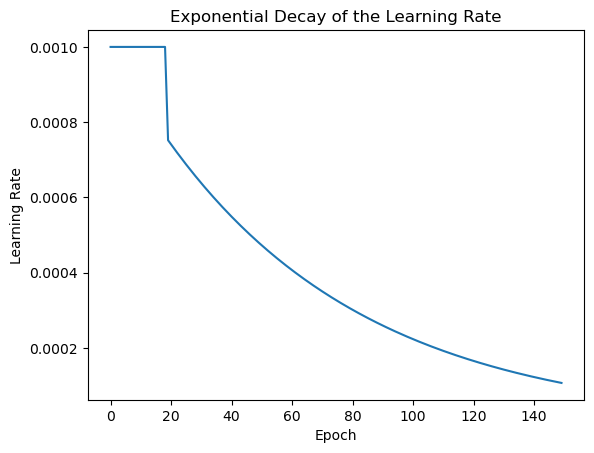

In [19]:
def exponential_decay(epoch,epochs=num_epochs,lr_ini=LR,decay_rate=DECAY_RATE):
    
    if epoch < epochs/(2**3): 
        return lr_ini
    else:
        return  lr_ini * np.exp(-decay_rate*epoch)

lr_scheduler = LearningRateScheduler(lambda epoch: exponential_decay(epoch))

epochs = np.arange(num_epochs)
learning_rates = [exponential_decay(epoch,num_epochs) for epoch in epochs]

plt.plot(epochs, learning_rates, label="Learning Rate")
plt.title("Exponential Decay of the Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(False)
plt.show()

#### <span style="color:blue">III.2. Loss function and metric </span>

The loss function to train the neural networks, and a reasonable reduction of the loss during the optimization was only possible when adding either the MSE or the MAE which combines with the mean relative error.

Definition of custom loss function MSE+

$$ MSE+ =  \sum_{P \in D} \frac{1}{|I_P|} \sum_{p \in I_P} ( \left\|u_p - \hat{u}_p \right\|_2^2 + C \frac{\left\|u_p - \hat{u}_p \right\|_2}{ \left\|u_p \right\|_2 + \varepsilon }) $$

Definition of custom loss function MAE+

$$MAE+ =  \frac{1}{|I_P|} \sum_{p \in I_P} (\left\|u_p - \hat{u}_p \right\|_1 + C \frac{ \left\| u_p - \hat{u}_p  \right\|_2 }{\left\| u_p  \right\|_2 + \varepsilon })$$

$u_p$ is the velocity prediction vector at the pixel $p$.

$\hat{u}_p$ is the reference speed in $p$.

$I_P$ is the set of all pixels $p$ that are not covered by the respective obstacle.

constants

$\varepsilon = 10^{-4}$

$ C = 10^{-2}$
#### [See baseline](https://etna.math.kent.edu/vol.56.2022/pp235-255.dir/pp235-255.pdf) 

In [20]:
def mseplus(u_true,u_pred):
    '''
    This is a custom function loss that calculate
    error between u_true and u_pred outside the obstacle
    '''
    
    error=u_true-u_pred
    mse=tf.reduce_sum(tf.square(error), axis=-1)                   # ||u_pred - u_true||_2^2
   
    norm_error=tf.sqrt(mse)                                        # ||u_pred - u_true||_2
                                 
    #norm_u_pred=tf.sqrt(tf.reduce_sum(tf.square(u_pred), axis=-1)) # ||u_pred||_2
    norm_u_true=tf.sqrt(tf.reduce_sum(tf.square(u_true), axis=-1))
    

    E = mse + C* norm_error/(norm_u_true + eps)
    # The filter in this line is designed to differentiate between pixels that are not equal to zero 
    # i.e. those that are located outside the obstacle.
    E = tf.boolean_mask(E, E>0)
    mse_plus=tf.reduce_mean(E)
    
    #Ip=tf.shape(mse_plus)
    #Ip = tf.cast(Ip, tf.float32)
    #mse_plus=tf.reduce_sum(mse_plus)/Ip
    
    return mse_plus

In [21]:
def maeplus(u_true,u_pred):
    '''
    This is a custom metric that calculate
    error between u_true and u_pred outside the obstacle
    same ideas as before 
    '''

    error=u_true-u_pred
    mae=tf.reduce_sum(tf.abs(error), axis=-1)

    norm_error=tf.sqrt(tf.reduce_sum(tf.square(error), axis=-1))
    #norm_u_pred=tf.sqrt(tf.reduce_sum(tf.square(u_pred),  axis=-1 ))
    norm_u_true=tf.sqrt(tf.reduce_sum(tf.square(u_true),  axis=-1 ))
    
    E = mae + C* norm_error/(norm_u_true + eps)
    condition = E > 0
    mae_plus = tf.boolean_mask(E, condition)
    mse_plus=tf.reduce_mean(mae_plus)
    
    #Ip=tf.shape(mae_plus)
    #Ip = tf.cast(Ip, tf.float32)
    #mae_plus=tf.reduce_sum(mae_plus)/Ip
    
    return mae_plus

    

### <span style="color:blue">IV. U-Net Architecture and Model</span>

In [22]:
func_activation='relu'
#func_activation='tanh'
kernel_size=3
num_classes=1

In [23]:
def u_net():
        input_shape=(h,w,ch)
        inputs = layers.Input(shape=input_shape)
    
         # ************  Encoder block  *************
        conv1 = layers.Conv2D(64, kernel_size, activation=func_activation, padding='same')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = layers.Conv2D(64, kernel_size, activation=func_activation, padding='same')(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = layers.Conv2D(128, kernel_size, activation=func_activation, padding='same')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = layers.Conv2D(128, kernel_size, activation=func_activation, padding='same')(conv2)
        conv2 = BatchNormalization()(conv2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
 
        conv3 = layers.Conv2D(256, kernel_size, activation=func_activation, padding='same')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = layers.Conv2D(256, kernel_size, activation=func_activation, padding='same')(conv3)
        conv3 = BatchNormalization()(conv3)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
       
        conv4 = layers.Conv2D(512, kernel_size, activation=func_activation, padding='same')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = layers.Conv2D(512, kernel_size, activation=func_activation, padding='same')(conv4)
        conv4 = BatchNormalization()(conv4)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = layers.Conv2D(1024, kernel_size, activation=func_activation, padding='same')(pool4)
        conv5 = layers.Conv2D(1024, kernel_size, activation=func_activation, padding='same')(conv5)
       
        # ************  Decoder block ****************
    
        up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(conv5)
        up6 = layers.concatenate([up6, conv4])
        conv6 = layers.Conv2D(512, kernel_size, activation=func_activation, padding='same')(up6)
        conv6 = layers.Conv2D(512, kernel_size, activation=func_activation, padding='same')(conv6)

        up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(conv6)
        up7 = layers.concatenate([up7, conv3])
        conv7 = layers.Conv2D(256, kernel_size, activation=func_activation, padding='same')(up7)
        conv7 = layers.Conv2D(256, kernel_size, activation=func_activation, padding='same')(conv7)

        up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv7)
        up8 = layers.concatenate([up8, conv2])
        conv8 = layers.Conv2D(128, kernel_size, activation=func_activation, padding='same')(up8)
        conv8 = layers.Conv2D(128, kernel_size, activation=func_activation, padding='same')(conv8)

        up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv8)
        up9 = layers.concatenate([up9, conv1])
        conv9 = layers.Conv2D(64, kernel_size, activation=func_activation, padding='same')(up9)
        conv9 = layers.Conv2D(64, kernel_size, activation=func_activation, padding='same')(conv9)

        outputs = layers.Conv2D(num_classes, (1,1), activation=func_activation,padding="same")(conv9)
    
        model = models.Model(inputs=[inputs], outputs=[outputs])
    
        model.summary()
        return model

In [ ]:
def execute_model(model):
    
        # **********************************************  Compile  and Fit model with Api  *******************************************
    
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/home/guiomar/Desktop/CODES/DLCODES-VER-4/result_saved/Best_weights.weights.h5",save_weights_only=True)
            
        optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9)
        
        model.compile(optimizer=optimizer, loss=mseplus, metrics=[maeplus])

        save_callback = SaveOutputCallback('/home/guiomar/Desktop/CODES/DLCODES-VER-4/result_saved/output_training.txt')
          
        history= model.fit(geo_array_train,mag_array_train,
                           batch_size=batch_size,validation_data=(geo_array_valid,mag_array_valid),
                           epochs=num_epochs,
                           callbacks=[early_stopping,checkpoint_cb,save_callback,lr_scheduler])
                           #callbacks=[early_stopping,checkpoint_cb,lr_scheduler])
        
        callbacks = [tf.keras.callbacks.ModelCheckpoint("/home/guiomar/Desktop/CODES/DLCODES-VER-4/result_saved/Unet.keras",save_best_only=True)]
        model.save('/home/guiomar/Desktop/CODES/DLCODES-VER-4/result_saved/Completed_Model.h5')
        show_results(history)
        return history


In [24]:
model=u_net()

I0000 00:00:1733200988.865179   81895 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 23:43:08.949813: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 128,   │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,038,273 (118.40 MB)

 Trainable params: 31,034,433 (118.39 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [25]:
path="/home/guiomar/Desktop/CODES/DLCODES-VER-4/result_saved/Best_weights.weights.h5"
model.load_weights(path)

In [10]:
# Some stadistics
df = pd.read_csv("/home/guiomar/Desktop/CODES/DLCODES-VER-4/result_saved/output_training.txt")  
print('\n Dataframe')
print(df.head(10))
print('\n Statistics')
stats=df[[' Mseplus', ' Maeplus',' Val_Mseplus',' Val_Maeplus']].describe()

print(stats)



 Dataframe
   Epoch   Mseplus   Maeplus   Val_Mseplus   Val_Maeplus
0      1  0.231146  0.370282     13.557180      3.890196
1      2  0.126141  0.287182      4.310045      2.142729
2      3  0.114941  0.291338      1.255752      1.096219
3      4  0.111283  0.286222      0.519515      0.649395
4      5  0.106321  0.274496      0.329275      0.471395
5      6  0.105390  0.270493      0.257509      0.416835
6      7  0.104141  0.270396      0.229066      0.393237
7      8  0.103115  0.270728      0.187575      0.349213
8      9  0.102411  0.270177      0.175423      0.335538
9     10  0.101591  0.268342      0.165765      0.326971

 Statistics
          Mseplus     Maeplus  Val_Mseplus  Val_Maeplus
count  148.000000  148.000000   148.000000   148.000000
mean     0.090872    0.246441     0.237750     0.314203
std      0.013549    0.016207     1.159727     0.343441
min      0.081652    0.229041     0.083764     0.234040
25%      0.084685    0.235676     0.088074     0.244389
50%      0.0

<Axes: title={'center': 'Training and Validation loss'}, xlabel='Epoch'>

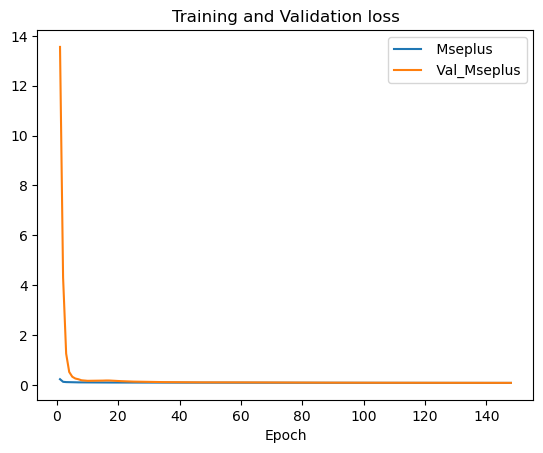

In [32]:
df.plot(x="Epoch", y=[" Mseplus", " Val_Mseplus"], kind="line", title="Training and Validation loss")


<Axes: title={'center': 'Training and Validation metric'}, xlabel='Epoch'>

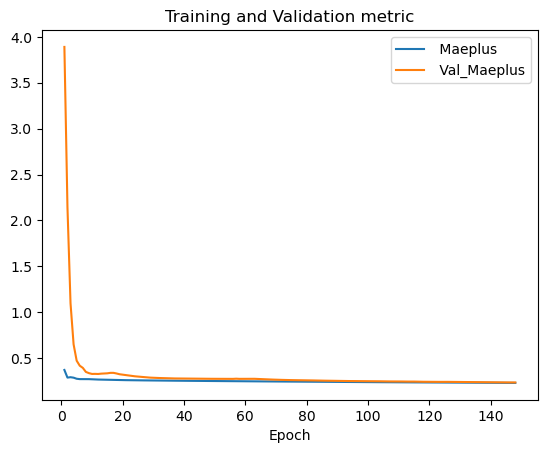

In [33]:
df.plot(x="Epoch", y=[" Maeplus", " Val_Maeplus"], kind="line", title="Training and Validation metric")

### <span style="color:blue">V. Evaluate</span>

In [26]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(geo_array_tests, mag_array_tests)
print("test loss, test metric:",results)

Evaluate on test data


ValueError: You must call `compile()` before using the model.

### <span style="color:blue">VI. Predictions</span>

In [27]:
u_predictions = model.predict(geo_array_tests) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


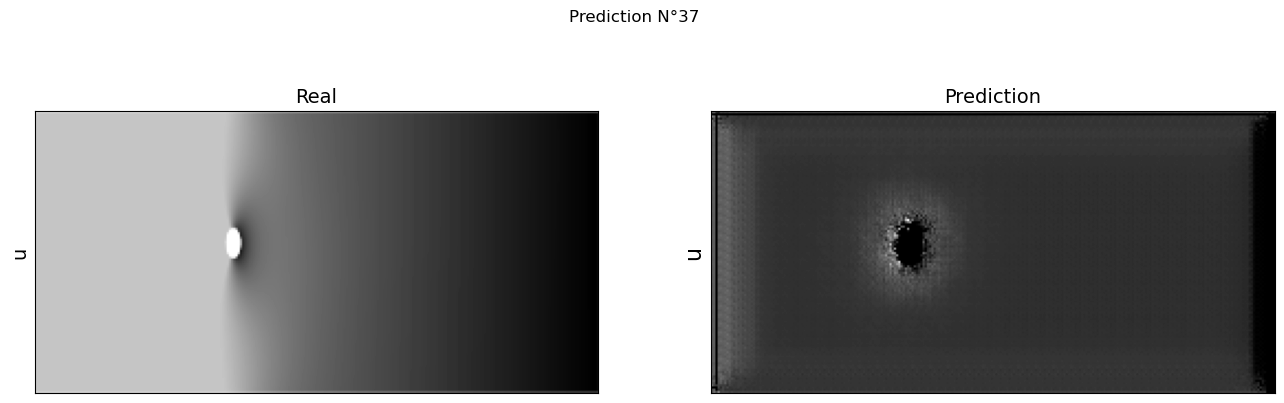

In [28]:

NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

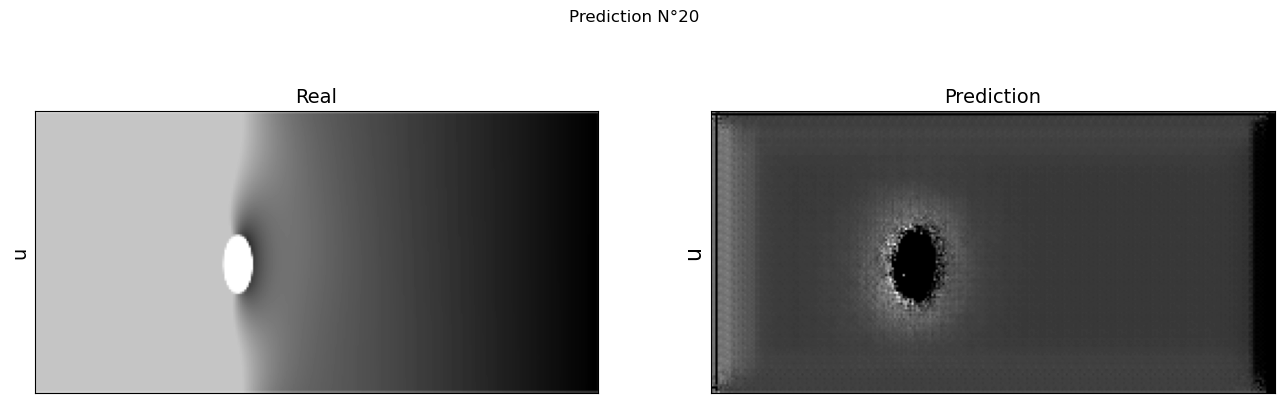

In [29]:

NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

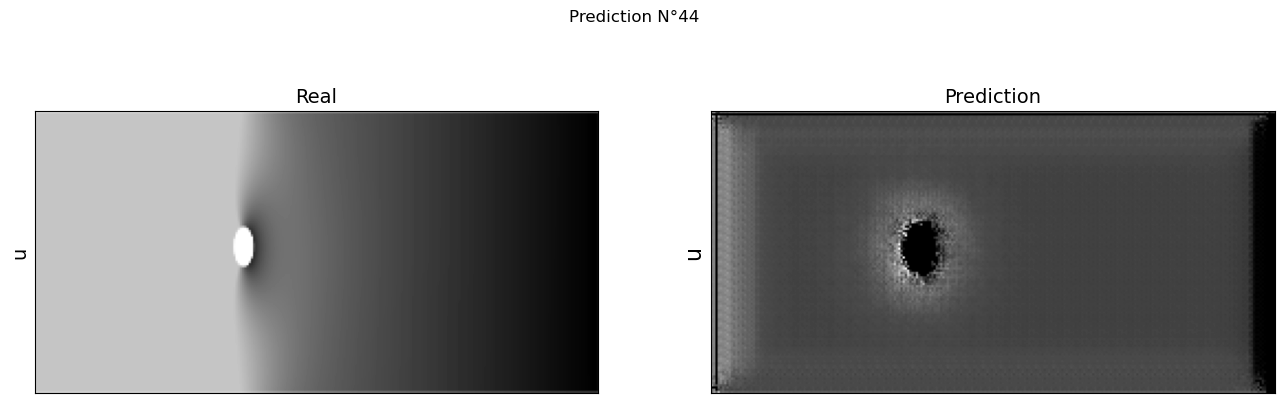

In [30]:

NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')